# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import pearsonr, spearmanr
import pywt

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
idx = pd.IndexSlice
%matplotlib inline


# To investigate

1. Find all the high alpha stocks in this time period
    * Define what it would look like if we bought the avg market index and the cumulative return 
    * Rank the cumulative returns of the stocks

# Prepare training dataframe

In [2]:
# prices_import=pd.read_csv("~/kaggle-data/jpx-stock-exchange-prediction/train_files/stock_prices.csv", parse_dates=['Date'])
# stock_list=pd.read_csv("~/kaggle-data/jpx-stock-exchange-prediction/stock_list.csv")
prices_import=pd.read_csv("train_files/stock_prices.csv", parse_dates=['Date'])
stock_list=pd.read_csv("stock_list.csv")

print("The train data begins on {} and ends on {}.\n".format(prices_import.Date.min(),prices_import.Date.max()))
display(prices_import.describe().style.format('{:,.2f}'))

prices =prices_import.rename({'SecuritiesCode':'Code'}, axis = 1).set_index(keys = ['Code', 'Date']).sort_index().copy()
dates = prices.index.get_level_values(1).unique()
securities = prices.index.get_level_values(0).unique()

The train data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,"2,332,531.00","2,332,531.00","2,324,923.00","2,324,923.00","2,324,923.00","2,324,923.00","2,332,531.00","2,332,531.00","18,865.00","2,332,293.00"
mean,",.2f","5,894.84","2,594.51","2,626.54","2,561.23","2,594.02","691,936.56",1.00,22.02,0.00
min,",.2f","1,301.00",14.00,15.00,13.00,14.00,0.00,0.10,0.00,-0.58
25%,",.2f","3,891.00","1,022.00","1,035.00","1,009.00","1,022.00","30,300.00",1.00,5.00,-0.01
50%,",.2f","6,238.00","1,812.00","1,834.00","1,790.00","1,811.00","107,100.00",1.00,15.00,0.00
75%,",.2f","7,965.00","3,030.00","3,070.00","2,995.00","3,030.00","402,100.00",1.00,30.00,0.01
max,",.2f","9,997.00","109,950.00","110,500.00","107,200.00","109,550.00","643,654,000.00",20.00,"1,070.00",1.12
std,nan,"2,404.16","3,577.19","3,619.36","3,533.49","3,576.54","3,911,255.94",0.07,29.88,0.02


In [3]:
stock_list['Section/Products'].value_counts()

Section/Products
First Section (Domestic)                                       2327
JASDAQ(Standard / Domestic)                                     726
Second Section(Domestic)                                        530
Mothers (Domestic)                                              439
ETFs/ ETNs                                                      277
REIT, Venture Funds, Country Funds and Infrastructure Funds      68
JASDAQ(Growth/Domestic)                                          41
First Section (Foreign)                                           4
Mothers (Foreign)                                                 3
JASDAQ(Standard / Foreign)                                        1
Second Section(Foreign)                                           1
Name: count, dtype: int64

In [4]:
# stock_list[stock_list['Section/Products']=='ETFs/ ETNs']

## Filter out late IPOs
Stocks that IPO'd in the middle of the time period of the dataset won't be trained on

In [5]:
# Check if each security has a complete date set
date_set = (prices.groupby('Code', group_keys=False).apply(lambda x: dates.isin(x.index.get_level_values(1)).all()))
bad_securities = date_set[~date_set].index
good_securities = date_set[date_set].index

prices = prices.loc[good_securities].copy()

## Appending the market index 
The index I'll use is NIKKEI 400 which has a securities code:1592.  It's located in the secondary training set

<Axes: xlabel='Date', ylabel='Close'>

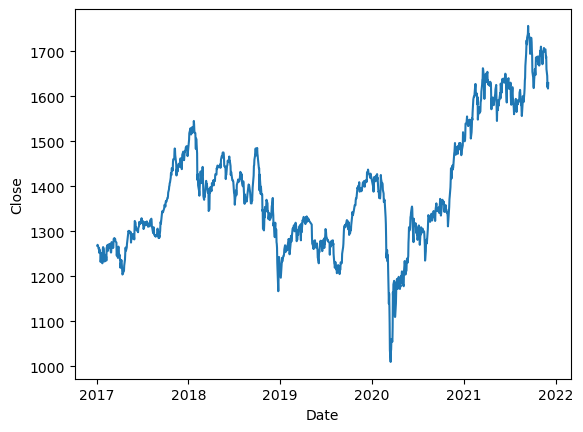

In [6]:
sec_stats = pd.read_csv('stock_list.csv').rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')

secondary_prices_import = pd.read_csv('train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondary_prices_import.Date = pd.to_datetime(secondary_prices_import.Date)
secondary_prices_import = secondary_prices_import.set_index(['Code', 'Date']).sort_index()

# Security code 1592 is a good approximatin to the Nikkei 225 index
prices = pd.concat([prices, secondary_prices_import.loc[idx[1592, :],:]]).sort_index()

fig, ax = plt.subplots()
sns.lineplot(data = prices.loc[1592], x='Date', y='Close')

## Merging fundamental data
not working at the moment because of forecast revisions

In [7]:
fund_import = pd.read_csv('train_files/financials.csv').rename(columns ={'SecuritiesCode': 'Code'})
fund_import = fund_import[~fund_import['Code'].isna()]
fund_import['Code']=fund_import['Code'].astype(int)
fund_import['Date'] = pd.to_datetime(fund_import['Date'])
fund_import = fund_import.set_index(['Code', 'Date']).sort_index()

quarterly_report_features = [
    'TypeOfDocument',
    'EarningsPerShare', 
    'Equity', 'EquityToAssetRatio', 'TotalAssets',
    'NetSales',
    'OperatingProfit', 'OrdinaryProfit', 'Profit', 
    'BookValuePerShare', 
    'ResultDividendPerShare1stQuarter',
    'ResultDividendPerShare2ndQuarter',
    'ResultDividendPerShare3rdQuarter',
    'ResultDividendPerShareAnnual',
    'ResultDividendPerShareFiscalYearEnd',
]

forecasted_fundamental_features =[
    'ForecastDividendPerShare1stQuarter',
    'ForecastDividendPerShare2ndQuarter',
    'ForecastDividendPerShare3rdQuarter',
    'ForecastDividendPerShareFiscalYearEnd',
    'ForecastNetSales',
    'ForecastOperatingProfit',
    'ForecastOrdinaryProfit',
    'ForecastProfit',
    'ForecastEarningsPerShare'
]
fundamental_features = quarterly_report_features + forecasted_fundamental_features
fund_import[fundamental_features[1:]]= fund_import[fundamental_features[1:]].apply(pd.to_numeric, errors='coerce')
fundamental = fund_import[fundamental_features]
fund_dup = fund_import.index[fund_import.index.duplicated()]
train = prices.copy()
train_dup = train.index[train.index.duplicated()]

# fund_import.loc[fund_dup[6], :].T

/tmp/ipykernel_50369/2465405705.py:1: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  fund_import = pd.read_csv('train_files/financials.csv').rename(columns ={'SecuritiesCode': 'Code'})


## Filtering out bad days
there was some bizarre outage on 2020-10-01


In [8]:
train = train[train.index.get_level_values(1) != '2020-10-01']

# for entries with no volume, make the OHLC the previous days close
# I'll probably throw these examples out since there's no actvitiy here
no_volume = train['Volume'] ==0
# train['Close'] =train.groupby('Code')['Close'].bfill()
# train.loc[no_volume, ['Open', 'High', 'Low']] = train.loc[no_volume, 'Close']

# Calculating $\beta$

In [9]:
train['AdjClose'] =train.groupby('Code', group_keys=False).apply(lambda x: x['Close']*(x['AdjustmentFactor'].cumprod()))
train['AdjVolume'] =train.groupby('Code', group_keys=False).apply(lambda x: x['Volume']/(x['AdjustmentFactor'].cumprod()))

# there are some bad reporting days that cause the returns to be incorrect
# In the original kaggle challenge the target was returns shifted ahead by 2 days, so I'll just shift those back by 2
train['returns'] = train.groupby('Code', group_keys=False)['Target'].shift(2)
train['returns_target'] = train.groupby('Code', group_keys=False)['Target'].shift(1)
# train['returns'] = train.groupby('Code', group_keys=False)['AdjClose'].apply(lambda x: x.pct_change())
train['cum_return'] = train.groupby('Code', group_keys=False)['returns'].apply(lambda x: (1+x).cumprod())

market_df = train.loc[1592]

In [10]:
# forecast window
target_window_span = 45
forward_window = pd.api.indexers.FixedForwardWindowIndexer(window_size=target_window_span)

def wavelet_smooth(signal, threshold = 0.2, level =3, wavelet = 'db6'):

    coeff = pywt.wavedec(signal, wavelet, mode = 'per', level =level)
    coeff[1:]  = [pywt.threshold(i, value=threshold*np.abs(signal.max()), mode = 'soft') for i in coeff[1:]]
    clean_signal = pywt.waverec(coeff, wavelet, mode = 'per')
    # return clean_signal
    if len(signal)%2 == 1:
        clean_series= pd.Series(clean_signal[:-1], signal.index)
    else:
        clean_series =  pd.Series(clean_signal, signal.index)
    return clean_series

def rolling_beta(df:pd.DataFrame, rolling_window, column, market_df=market_df):
    Y_series= df[column]
    X_series = market_df[column]
    XY_series = X_series * Y_series
    XY_mean = XY_series.rolling(window=rolling_window).mean()
    X_mean = X_series.rolling(window=rolling_window).mean()
    Y_mean = Y_series.rolling(window=rolling_window).mean()
    X_variance = X_series.rolling(window=rolling_window).var()
    return (XY_mean - X_mean * Y_mean) / X_variance


train['beta_45avg']=train.groupby('Code', group_keys=False).apply(
    rolling_beta, rolling_window=target_window_span, column='returns'
)
train['beta_target_1'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-1).ffill()
train['beta_target_5'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-5).ffill()
train['beta_target_20'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-20).ffill()
train['beta_target_45'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-45).ffill()
train['beta_target']=train['beta_target_45']
# train['dbeta'] = train.groupby('Code', group_keys=False)['beta_target'].apply(lambda x: x.diff().fillna(x.diff().mean()))
# train['dbeta_sm']=train.groupby('Code', group_keys = False)['dbeta'].apply(wavelet_smooth, level = 4, threshold = 0.15)


## Checking the autocorrelation in the 45 day $\beta$

<Axes: xlabel='beta_target_1', ylabel='Count'>

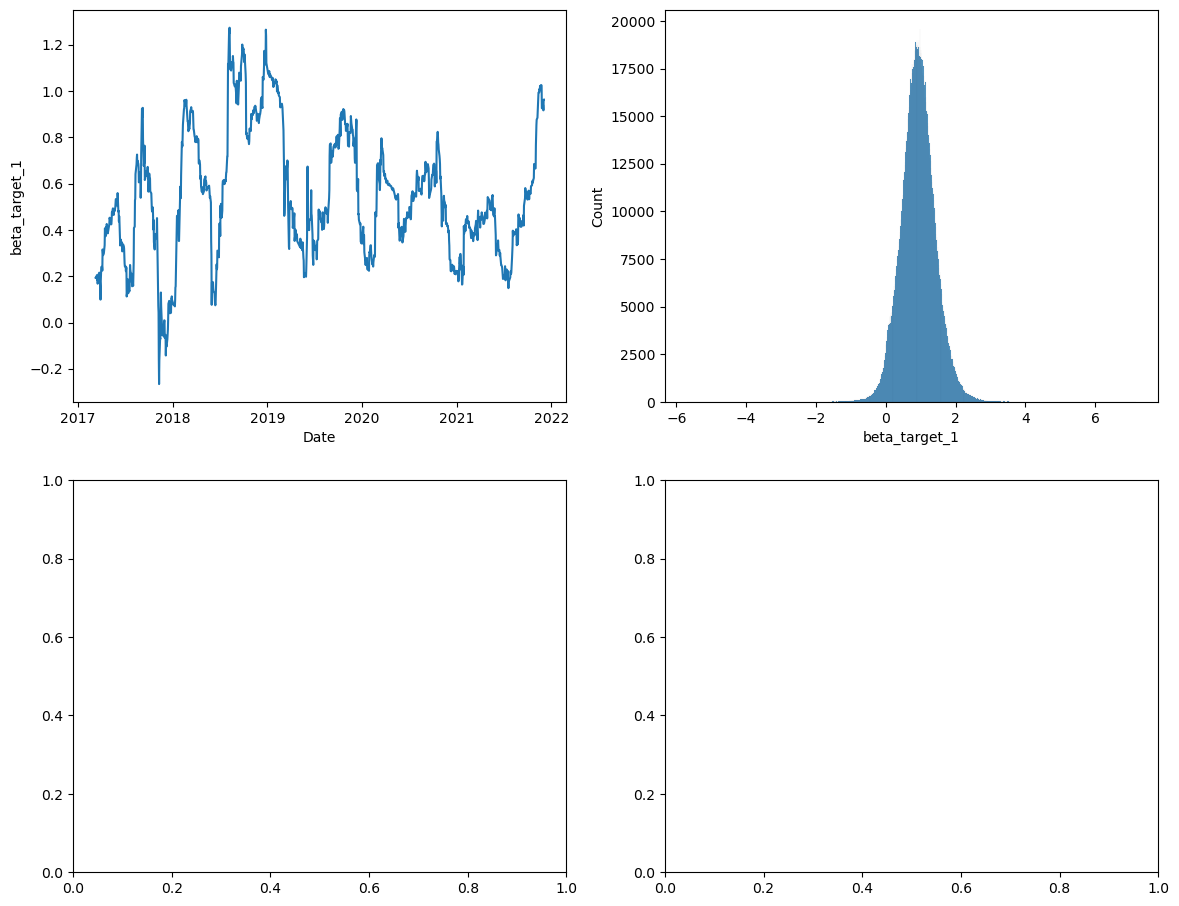

In [11]:
df = train.loc[1301]

fig, ax = plt.subplots(figsize = (14, 5.6*2), nrows = 2, ncols = 2)

sns.lineplot(df, x='Date', y = 'beta_target_1', ax = ax[0,0])
sns.histplot(train, x='beta_target_1', ax = ax[0,1])
# sns.lineplot(df, x='Date', y = 'dbeta', ax = ax[1,0])
# sns.lineplot(df, x='Date', y = 'dbeta_sm', ax = ax[1,0])
# sns.histplot(train, x='dbeta_sm', ax = ax[1,1], color ='tab:orange')

## Autocorrelation

In [12]:
train[['beta_45avg', 'beta_target_1']]

beta_45avg  beta_target_1
Code Date                                 
1301 2017-01-04         NaN            NaN
     2017-01-05         NaN            NaN
     2017-01-06         NaN            NaN
     2017-01-10         NaN            NaN
     2017-01-11         NaN            NaN
...                     ...            ...
9997 2021-11-29    0.574030       0.443045
     2021-11-30    0.443045       0.503841
     2021-12-01    0.503841       0.479004
     2021-12-02    0.479004       0.561283
     2021-12-03    0.561283       0.561283

[2241066 rows x 2 columns]

<Axes: xlabel='beta_45avg', ylabel='beta_target_1'>

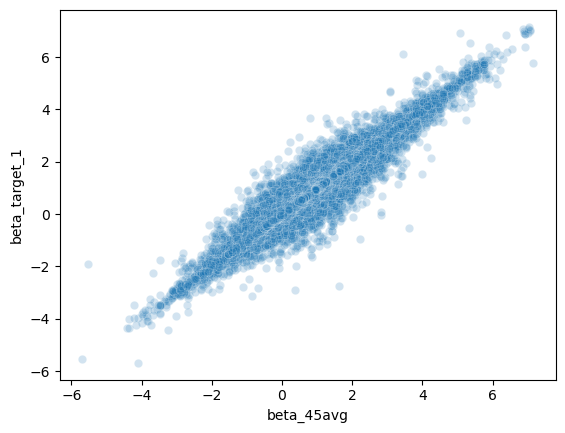

In [13]:
fig, ax = plt.subplots()

sns.scatterplot(train, x='beta_45avg', y='beta_target_1' , alpha = 0.2) 
# sns.scatterplot(train, x='beta_45avg', y='beta_target_5',  alpha = 0.2)
# sns.scatterplot(train, x='beta_45avg', y='beta_target_20', alpha = 0.2)
# sns.scatterplot(train, x='beta_45avg', y='beta_target_45', alpha = 0.2)
# ax.plot(*train[['beta_45avg', 'beta_target_1']].dropna().values.T)

## Calculate target alpha
Take a 45 period rolling average of the future 5 day returns

In [14]:
# train['returns_5d'] = train.groupby('Code', group_keys=False)['cum_return'].apply(lambda x: x.pct_change(-1)).ffill()
train['returns_45avg'] =train.groupby('Code', group_keys=False)['Target'].rolling(forward_window).mean().droplevel(0).ffill()
train['alpha'] = train.groupby('Code', group_keys=False).apply(lambda x: x.returns_45avg-train.loc[1592, 'returns_45avg'])

In [15]:
# train['cum_alpha'] =train.groupby('Code', group_keys=False)['alpha'].apply(lambda x: (x+1).cumprod())

In [16]:
# df = train.loc[1301]

# fig, ax = plt.subplots(figsize = (14, 5.6*2), nrows = 2, ncols = 2)

# sns.lineplot(df, x='Date', y = 'alpha', ax = ax[0,0])
# # sns.histplot(train, x='alpha', ax = ax[0,1])
# # sns.lineplot(df, x='Date', y = 'dbeta', ax = ax[1,0])
# # sns.lineplot(df, x='Date', y = 'dbeta_sm', ax = ax[1,0])
# # sns.histplot(train, x='dbeta_sm', ax = ax[1,1], color ='tab:orange')

## Look at the top 3 and bottom 3 beta stocks

In [17]:
sec_stats = pd.DataFrame(index = train.index.get_level_values(0).unique())
sec_stats['avg_alpha'] = train.groupby('Code', group_keys=False)['alpha'].mean()
sec_stats['alpha_rank'] = np.abs(sec_stats.avg_alpha).rank(ascending = False)
sec_stats['avg_beta'] = train.groupby('Code', group_keys=False)['beta_target'].mean()
sec_stats['beta_rank'] = np.abs(sec_stats.avg_beta).rank(ascending = False)
sec_stats.sort_values(by = 'beta_rank',inplace=True)


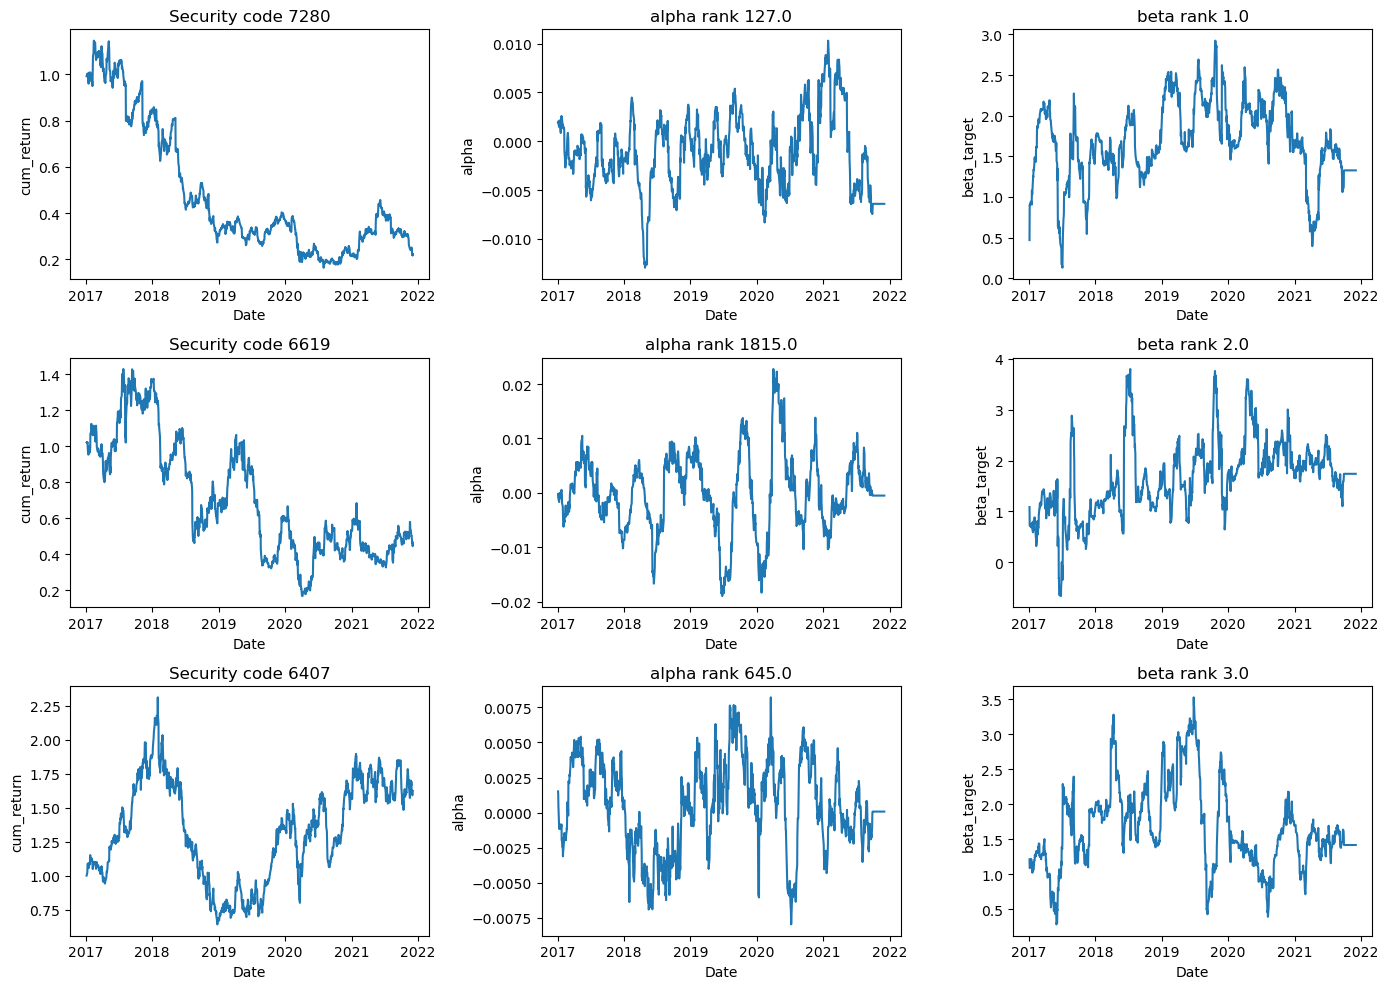

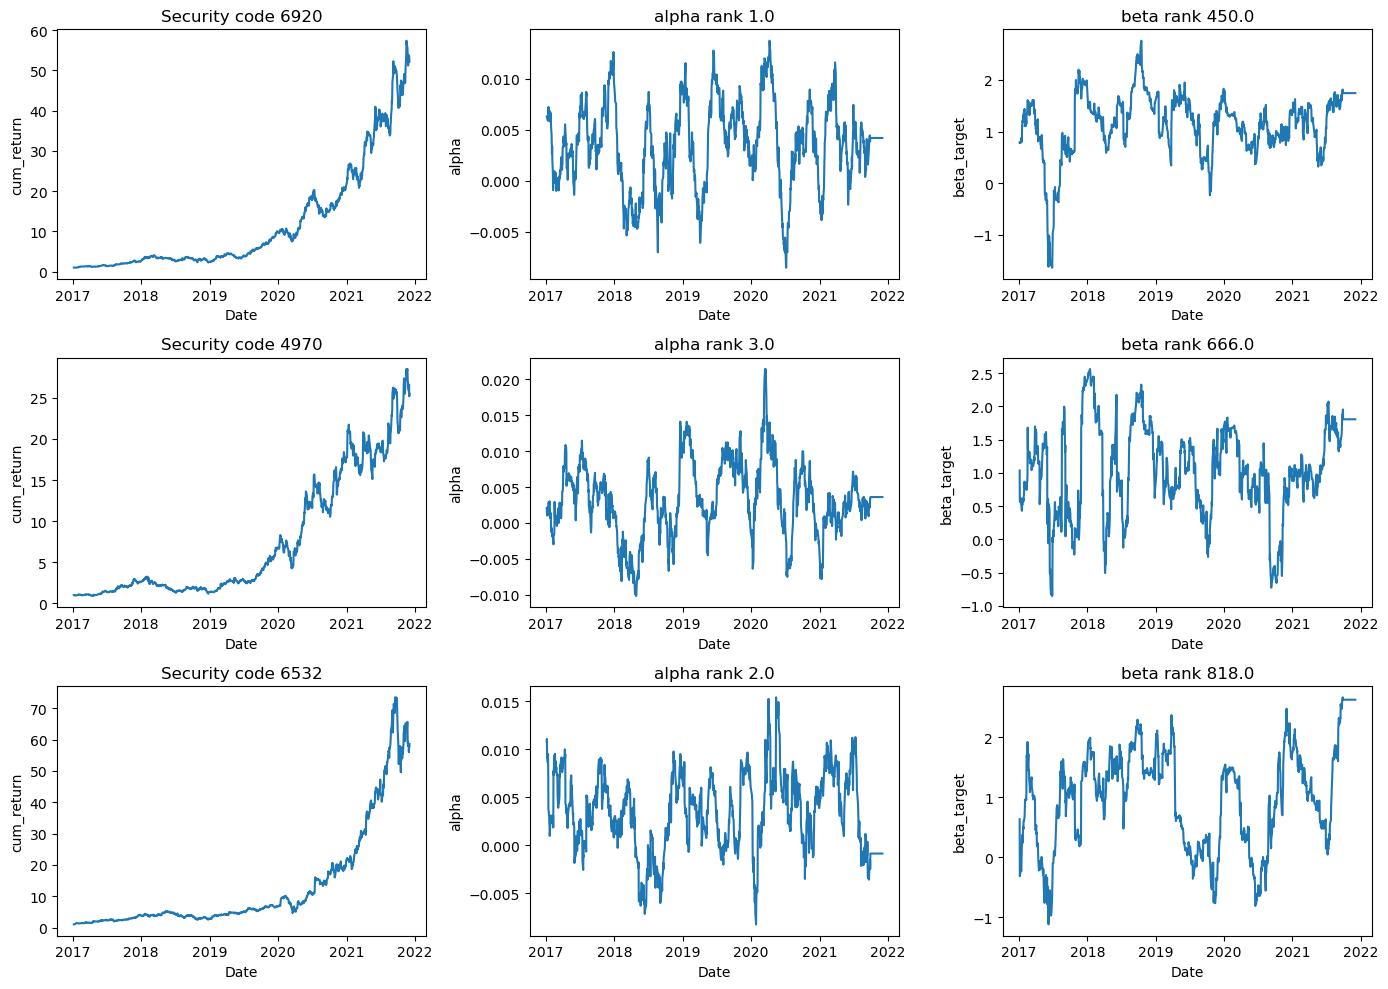

In [18]:
%matplotlib inline
top3_betas = sec_stats[sec_stats.beta_rank<=3].index.to_list()

top3_alphas = sec_stats[sec_stats.alpha_rank<=3].index.to_list()

train.loc[top3_betas]

def plot_target_timeseries(tickers:list, targets:list=None, df:pd.DataFrame =None):
    if df ==None: df =  train
    if targets ==None: targets = ['alpha', 'beta_target']
    targets = ['cum_return'] + targets

    fig, ax = plt.subplots(len(tickers), len(targets), figsize = (14,10))
    for i, tick in enumerate(tickers):
        ax[i, 0].set_title('Security code {:}'.format(tick))
        ax[i, 1].set_title('alpha rank {:}'.format(sec_stats.loc[tick, 'alpha_rank']))
        ax[i, 2].set_title('beta rank {:}'.format(sec_stats.loc[tick, 'beta_rank']))
        for j, targ in enumerate(targets):
            sns.lineplot(df.loc[tick], x= 'Date', y = targ, ax = ax[i, j])
        
    fig.tight_layout()
plot_target_timeseries(top3_betas)
plot_target_timeseries(top3_alphas)

<Axes: xlabel='avg_beta', ylabel='Count'>

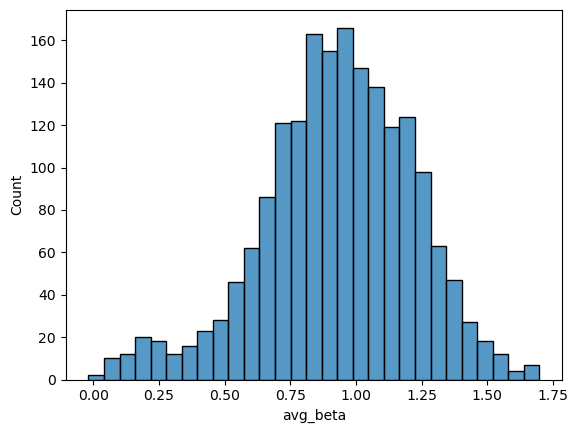

In [19]:
fig, ax = plt.subplots()
sns.histplot(sec_stats, x='avg_beta')

## Options

In [20]:
options_import = pd.read_csv('train_files/options.csv')
options_import['Date'] = pd.to_datetime(options_import['Date'])
options_import['Code']=options_import['OptionsCode'].astype(str).str[:4].astype(int)
# options_import['id'] =options_import['DateCode'].astype(str).str[:13].astype(int)
options_indices = [
    'Code', 'Date',
    'StrikePrice', 
    # 'PutCall', 'ContractMonth',
]
options_import = options_import.set_index(options_indices).sort_index()

/tmp/ipykernel_50369/3009579727.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options_import = pd.read_csv('train_files/options.csv')


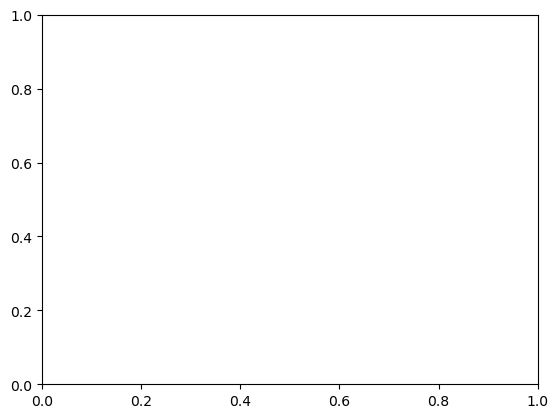

In [21]:
active_set = options_import['WholeDayVolume'] >1000
options = options_import[active_set].copy()
fig, ax = plt.subplots()

# sns.histplot(data =options, x ='WholeDayVolume')
# sns.scatterplot(data = options, x= 'Date', y ='WholeDayVolume')

In [22]:
options.loc[idx[1320, '2017-01-04'], :].T

StrikePrice,16500.0,17000.0,17250.0,17375.0,17500.0,17750.0,17875.0,18000.0,18125.0,18250.0,18375.0,18500.0,18625.0,18750.0,18875.0,19000.0,19125.0,19250.0,19375.0,19500.0
DateCode,20170104_132016518,20170104_132017018,20170104_132017218,20170104_132017318,20170104_132017518,20170104_132017718,20170104_132017818,20170104_132018018,20170104_132018118,20170104_132018218,20170104_132018318,20170104_132018518,20170104_132018618,20170104_132018718,20170104_132018818,20170104_132019018,20170104_132019118,20170104_132019218,20170104_132019318,20170104_132019518
OptionsCode,132016518,132017018,132017218,132017318,132017518,132017718,132017818,132018018,132018118,132018218,132018318,132018518,132018618,132018718,132018818,132019018,132019118,132019218,132019318,132019518
WholeDayOpen,5.0,12.0,15.0,19.0,23.0,33.0,39.0,47.0,55.0,70.0,80.0,95.0,115.0,145.0,170.0,210.0,255.0,315.0,450.0,420.0
WholeDayHigh,8.0,15.0,19.0,24.0,28.0,38.0,46.0,60.0,65.0,80.0,95.0,115.0,135.0,170.0,205.0,250.0,305.0,375.0,450.0,510.0
WholeDayLow,1.0,1.0,2.0,3.0,3.0,5.0,6.0,8.0,11.0,13.0,16.0,20.0,24.0,31.0,41.0,55.0,70.0,90.0,120.0,155.0
WholeDayClose,1.0,2.0,3.0,3.0,4.0,6.0,6.0,8.0,11.0,13.0,16.0,21.0,24.0,31.0,41.0,55.0,70.0,90.0,120.0,155.0
NightSessionOpen,5.0000,12.0000,15.0000,19.0000,23.0000,33.0000,39.0000,47.0000,55.0000,70.0000,80.0000,95.0000,115.0000,145.0000,170.0000,210.0000,255.0000,315.0000,450.0000,420.0000
NightSessionHigh,8.0000,15.0000,19.0000,24.0000,28.0000,38.0000,46.0000,60.0000,65.0000,80.0000,95.0000,115.0000,135.0000,170.0000,205.0000,250.0000,305.0000,375.0000,450.0000,510.0000
NightSessionLow,5.0000,11.0000,15.0000,17.0000,22.0000,32.0000,38.0000,46.0000,55.0000,70.0000,80.0000,90.0000,115.0000,140.0000,170.0000,205.0000,255.0000,315.0000,450.0000,420.0000
NightSessionClose,7.0000,11.0000,17.0000,19.0000,25.0000,35.0000,41.0000,60.0000,65.0000,80.0000,90.0000,115.0000,130.0000,170.0000,205.0000,250.0000,300.0000,375.0000,450.0000,510.0000


# Feature engineering

In [23]:

# Feature calculation functions

def pandas_winsor(series, limit = 1-0.99):
    return pd.Series(winsorize(series, limits = limit).data, index =series.index)

def wavelet_smoother(feature, data:pd.DataFrame=None):
    return

# Plotting functions

def feature_timeseries_plot(tickers:list, feature, target, df:pd.DataFrame = None):
    if df == None: df = train

    fig, ax = plt.subplots(2, len(tickers), figsize = (14, 10))

    for i , tick in enumerate(tickers):
        ax[0, i].set_title('Security code {:}'.format(tick))
        ax[1, i].set_title('beta rank {:}'.format(sec_stats.loc[tick, 'beta_rank']))        
        sns.lineplot(df.loc[tick], x= 'Date', y = target, ax = ax[0, i])
        sns.lineplot(df.loc[tick], x= 'Date', y = feature, ax = ax[1, i])
    return

def beta_feature_scatter(feature, spearman = False, df:pd.DataFrame = None,):
    '''
    2 scatter plots of the beta and beta differences vs. the feature
    '''
    fig, ax = plt.subplots(ncols= 2, figsize = (9.2*1.5,5.6))
    feature_scatter(feature, 'beta_target', spearman, df, fig =fig, ax = ax[0])
    # feature_scatter(feature, 'dbeta_sm', df=df,fig =fig, ax = ax[1])

def feature_scatter(feature, target, spearman=False, df:pd.DataFrame=None, fig =None, ax = None):

    if df ==None:
        df = train.loc[train.index.get_level_values(0)!=1592]
    if ax ==None:
        fig, ax = plt.subplots()
    df=df[[feature, target]].dropna()
    sns.scatterplot(data = df, x = feature, y = target, ax = ax)

    pearson_r = pearsonr(df[feature], df[target])[0]
    print(f'{target} vs {feature} pearson r={pearson_r}')
    ax.set_title('{:} has pearson r of {:.3g}'.format(feature, pearson_r))

    if spearman:
        spearman_r = spearmanr(df[feature], df[target])[0]
        print(f'{target} vs {feature} spearman r={spearman_r}')
    
def feature_heatmap(feat_list:list,targets:list = None, data:pd.DataFrame =None, ):
    '''
    Plots a heat map of the correaltion matrix
    '''
    fig, ax = plt.subplots(figsize = (14, 14))

    if data == None: data = train
    if targets == None: targets = ['beta_target']
    cols = feat_list + targets
    sns.heatmap(data[cols].dropna().corr(), ax = ax, cmap = 'viridis',annot=True, fmt = '.2g')


## Feature engineering

* price features
    * standard deviation in returns
    * Bollinger band feature
    * ratio of return to market avg returns
    * average true range 
    * other candle features
    
* Fundamental features
* Implied volatility of atm options
        

beta_target vs beta_45avg pearson r=0.4075698771686663


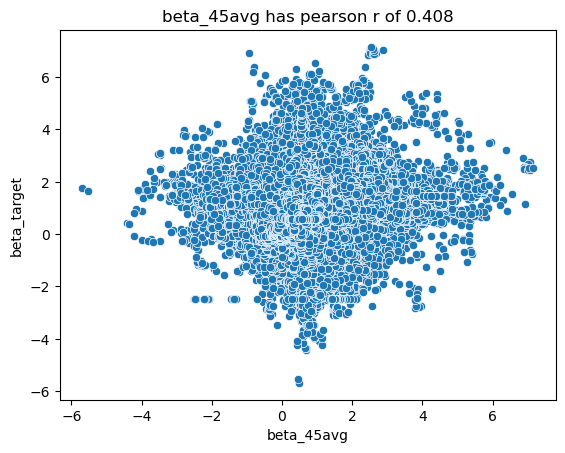

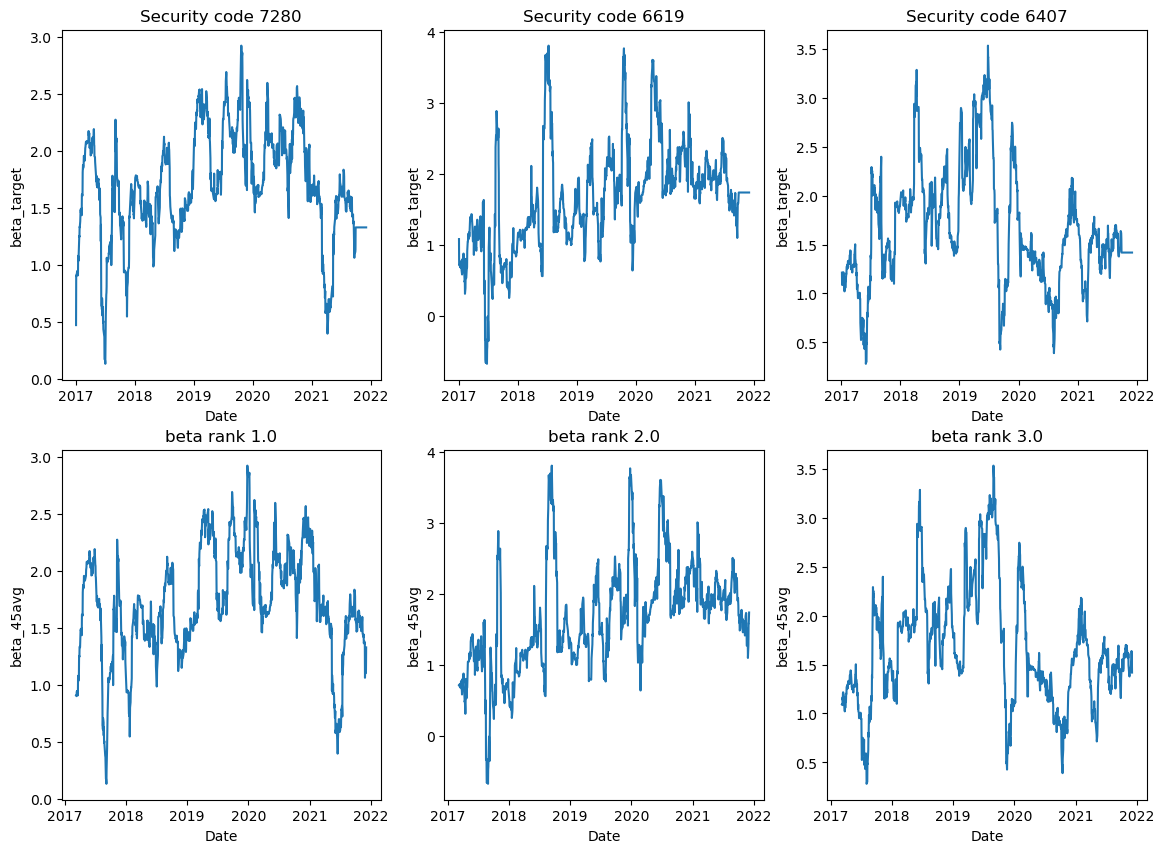

In [24]:
# df[np.abs(df['returns']/df['target_lag2']-1)>1E-6].index.get_level_values(1).value_counts()
# train['covar_hist_i'] = train.groupby('Code', group_keys=False)['returns'].apply(lambda x: x*train.loc[1592, 'returns'])
# train['covar_hist'] = train.groupby('Code', group_keys=False)['covar_hist_i'].rolling(45).mean().droplevel(0).bfill()
# train['beta_hist'] = train.groupby('Code', group_keys=False)['covar_hist'].apply(lambda x: x/train.loc[1592, 'covar_hist'])


feature_scatter('beta_45avg', 'beta_target')
feature_timeseries_plot(top3_betas, 'beta_45avg', target = 'beta_target')

### Volatility
The standard deviation in returns


10 day period

In [25]:
def calc_volatility(_win, data:pd.DataFrame =None):
    if data ==None: data = train
    col_name = f'sigma_{_win}'
    data[col_name] = data.groupby('Code', group_keys=False)['returns'].apply(
        pandas_winsor).groupby('Code').rolling(_win).std().bfill().droplevel(0)
    return data
    # return data[col_name]

# def wavelet_smoother(feat, data:pd.DataFrame=None):
#     if data == None: data = train
#     col_name = f'{feat}_sm'
#     data[col_name] = data.groupby('Code', group_keys=False).apply(lambda)

In [26]:
vol_windows = [5, 15, 30, 45]
for w in vol_windows: calc_volatility(w)

In [27]:
# train['sigma_10']=train.groupby('Code', group_keys=False)['returns'].apply(
#     pandas_winsor).groupby('Code').rolling(20).std().bfill().droplevel(0)
# train['sigma_10sm']=train.groupby('Code', group_keys=False)['sigma_10'].apply(lambda x: wavelet_smooth(pandas_winsor(x.diff().bfill())))
# beta_feature_imp('sigma_10sm')

beta_target vs sigma_45 pearson r=0.29862941531011683


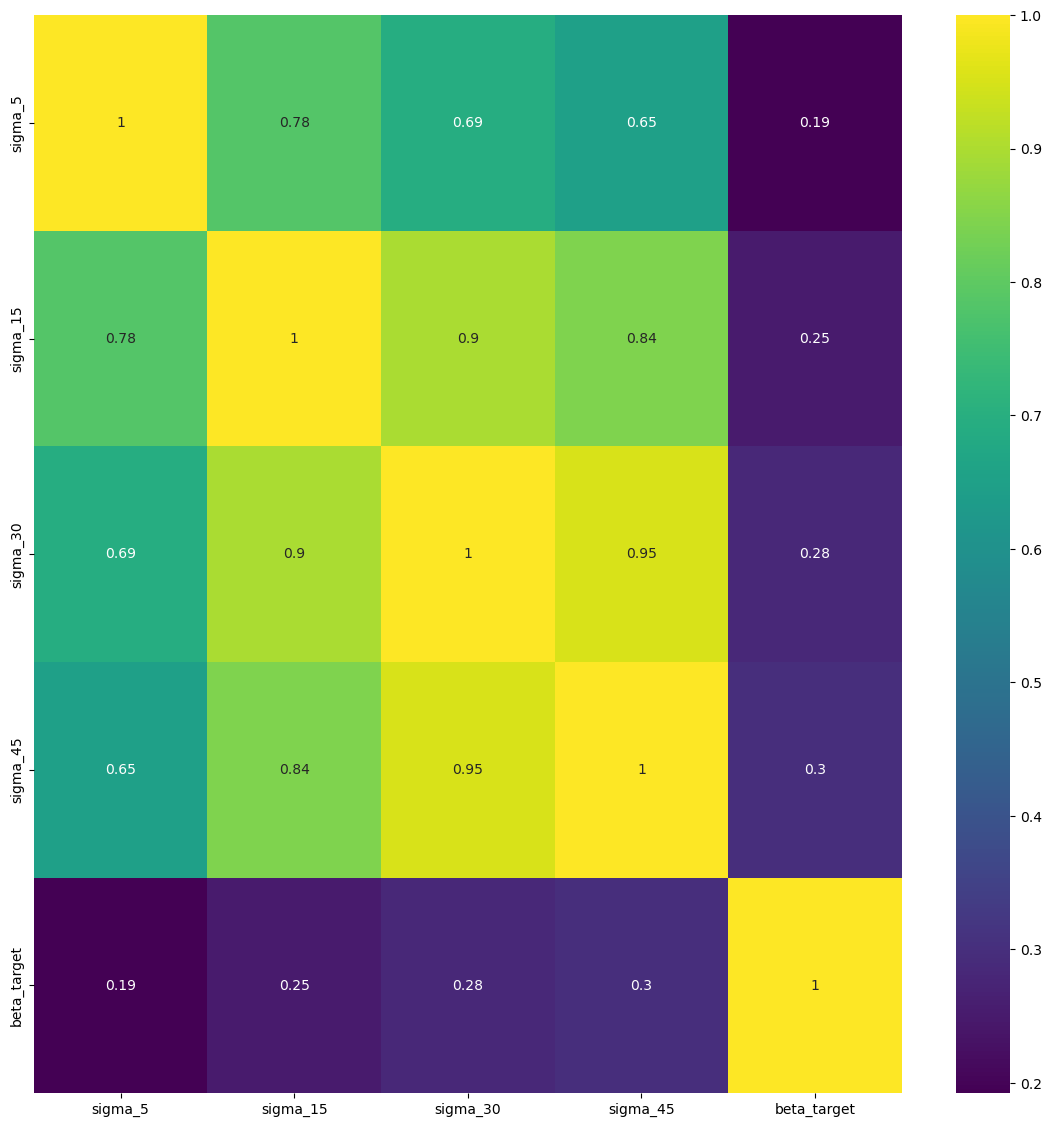

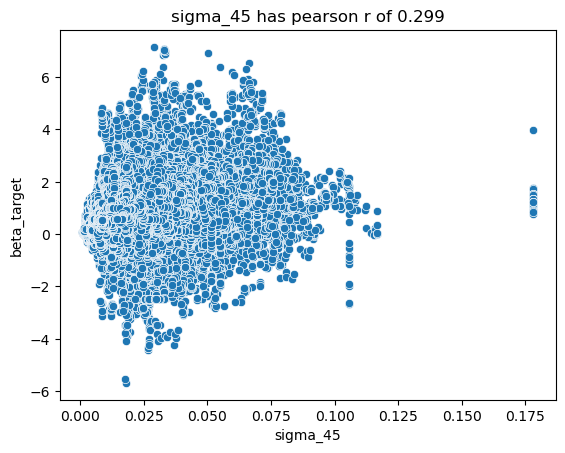

In [28]:
feature_heatmap([f'sigma_{i}' for i in vol_windows])
# beta_feature_scatter('sigma_45')
feature_scatter('sigma_45', 'beta_target')

## Return to spy return ratio

In [29]:
# def calc_return_ratio


train['sigma_ratio'] = train.groupby('Code', group_keys=False)['sigma_15'].apply(lambda x: x/train.loc[1592, 'sigma_15'])
# beta_feature_imp('sigma_ratio')

## Bollinger band feature

In [30]:
def calc_bbands(periods:list, data:pd.DataFrame = None):
    if data == None: data = train
    for p in periods:
        bbmid_col = f'sma_{p}'
        data[bbmid_col] = data.groupby('Code')['cum_return'].rolling(p).mean().droplevel(0)
        bb_std = data.groupby('Code')['cum_return'].rolling(p).std().droplevel(0)
        data[f'bbhigh_{p}'] = data[bbmid_col] + 2*bb_std
        data[f'bblow_{p}'] = data[bbmid_col] - 2*bb_std
        data[f'bbceil_{p}'] = 1-data['cum_return']/data[f'bbhigh_{p}']
        data[f'bbfloor_{p}'] = 1-data[f'bblow_{p}']/data['cum_return']
        # data[f'bbdiff_{p}'] = data[f'bbceil_{p}']+data[f'bbfloor_{p}']

calc_bbands(vol_windows)
train

RowId    Open    High     Low   Close  Volume  \
Code Date                                                                
1301 2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   31400   
     2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   17900   
     2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   19900   
     2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   24200   
     2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0    9300   
...                        ...     ...     ...     ...     ...     ...   
9997 2021-11-29  20211129_9997   678.0   679.0   665.0   668.0  320800   
     2021-11-30  20211130_9997   670.0   689.0   667.0   667.0  296300   
     2021-12-01  20211201_9997   661.0   688.0   660.0   685.0  339100   
     2021-12-02  20211202_9997   681.0   692.0   680.0   684.0  342900   
     2021-12-03  20211203_9997   690.0   711.0   686.0   696.0  381100   

                 AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Code Date                                                              
1301 2017-01-04               1.0               NaN            False   
     2017-01-05               1.0               NaN            False   
     2017-01-06               1.0               NaN            False   
     2017-01-10               1.0               NaN            False   
     2017-01-11               1.0               NaN            False   
...                           ...               ...              ...   
9997 2021-11-29               1.0               NaN            False   
     2021-11-30               1.0               NaN            False   
     2021-12-01               1.0               NaN            False   
     2021-12-02               1.0               NaN            False   
     2021-12-03               1.0               NaN            False   

                   Target  ...    sma_30  bbhigh_30  bblow_30  bbceil_30  \
Code Date                  ...                                             
1301 2017-01-04  0.000730  ...       NaN        NaN       NaN        NaN   
     2017-01-05  0.002920  ...       NaN        NaN       NaN        NaN   
     2017-01-06 -0.001092  ...       NaN        NaN       NaN        NaN   
     2017-01-10 -0.005100  ...       NaN        NaN       NaN        NaN   
     2017-01-11 -0.003295  ...       NaN        NaN       NaN        NaN   
...                   ...  ...       ...        ...       ...        ...   
9997 2021-11-29  0.026987  ...  0.949491   1.063840  0.835141   0.220418   
     2021-11-30 -0.001460  ...  0.942621   1.060616  0.824625   0.219219   
     2021-12-01  0.017544  ...  0.936454   1.053709  0.819200   0.192892   
     2021-12-02  0.014368  ...  0.930454   1.046479  0.814428   0.188503   
     2021-12-03  0.018414  ...  0.925363   1.039086  0.811641   0.168390   

                 bbfloor_30    sma_45  bbhigh_45  bblow_45  bbceil_45  \
Code Date                                                               
1301 2017-01-04         NaN       NaN        NaN       NaN        NaN   
     2017-01-05         NaN       NaN        NaN       NaN        NaN   
     2017-01-06         NaN       NaN        NaN       NaN        NaN   
     2017-01-10         NaN       NaN        NaN       NaN        NaN   
     2017-01-11         NaN       NaN        NaN       NaN        NaN   
...                     ...       ...        ...       ...        ...   
9997 2021-11-29   -0.006982  0.979219   1.106390  0.852047   0.250399   
     2021-11-30    0.004207  0.974059   1.106506  0.841612   0.251600   
     2021-12-01    0.036753  0.969341   1.103970  0.834713   0.229637   
     2021-12-02    0.040964  0.965010   1.102310  0.827710   0.229604   
     2021-12-03    0.060725  0.960982   1.099268  0.822695   0.213919   

                 bbfloor_45  
Code Date                    
1301 2017-01-04         NaN  
     2017-01-05         NaN  
     2017-01-06         NaN  
     2017-01-10         NaN  
     2

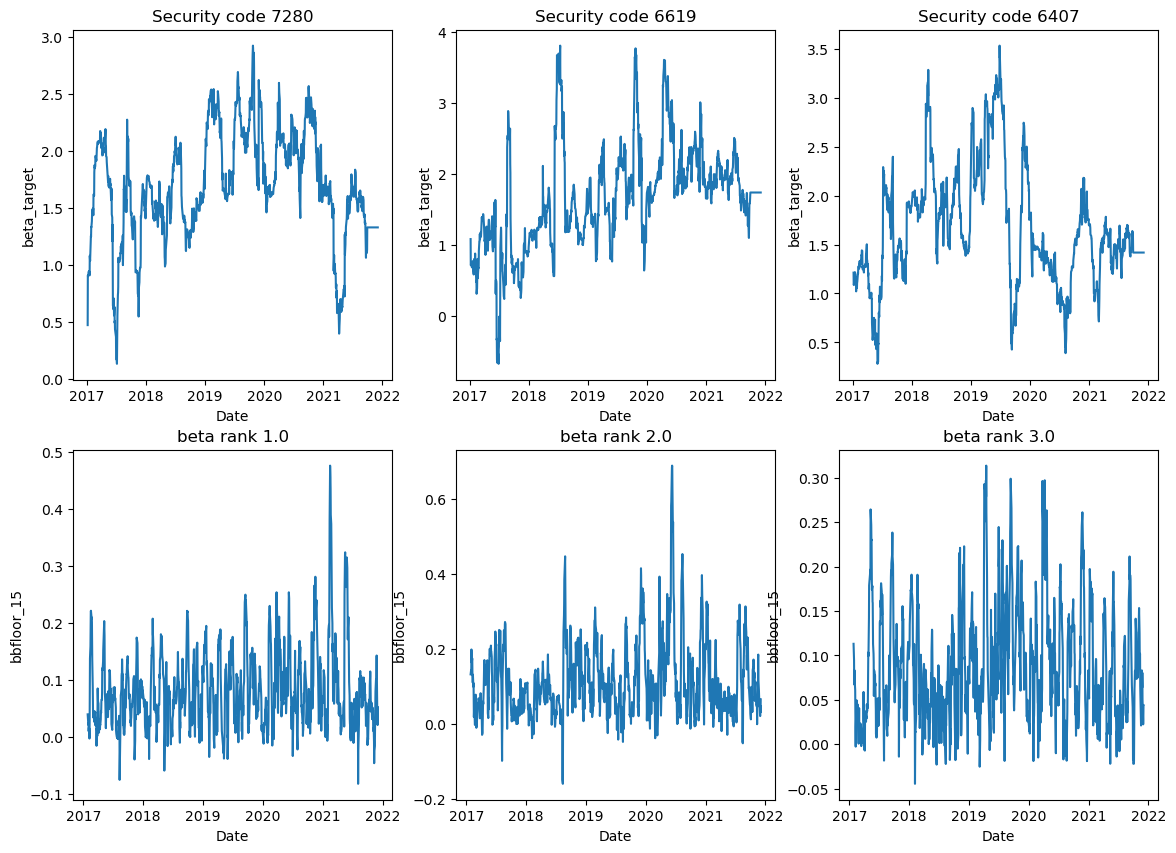

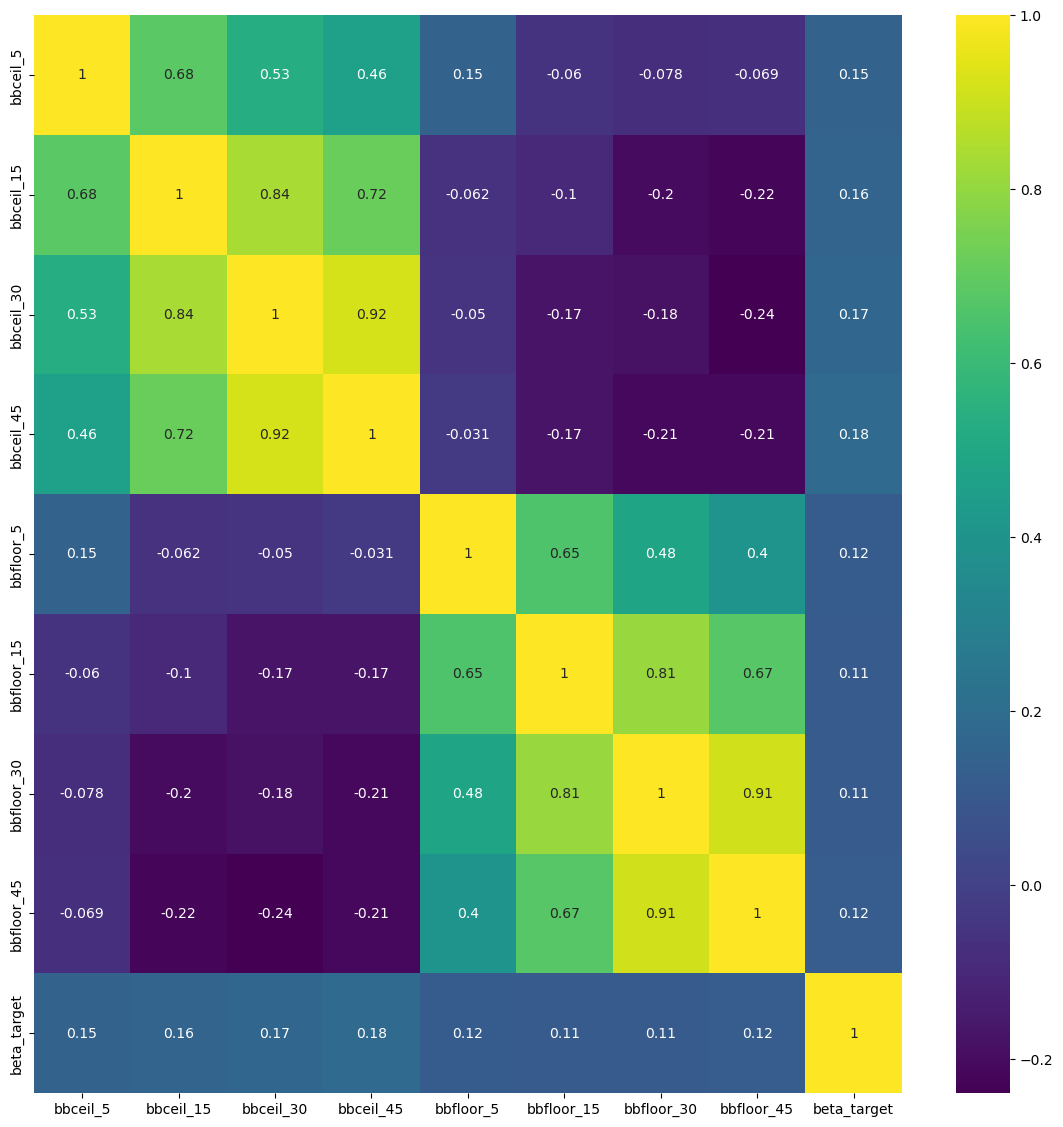

In [31]:
feature_timeseries_plot(top3_betas, 'bbfloor_15', 'beta_target')

bb_feats = [f'bbceil_{i}' for i in vol_windows]+[f'bbfloor_{i}' for i in vol_windows]#+[f'bbdiff_{i}' for i in vol_windows]
feature_heatmap(bb_feats, targets = ['beta_target'])

## ATR features

In [32]:
train['ATR_1'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_2'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Open'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_3'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['Open'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)

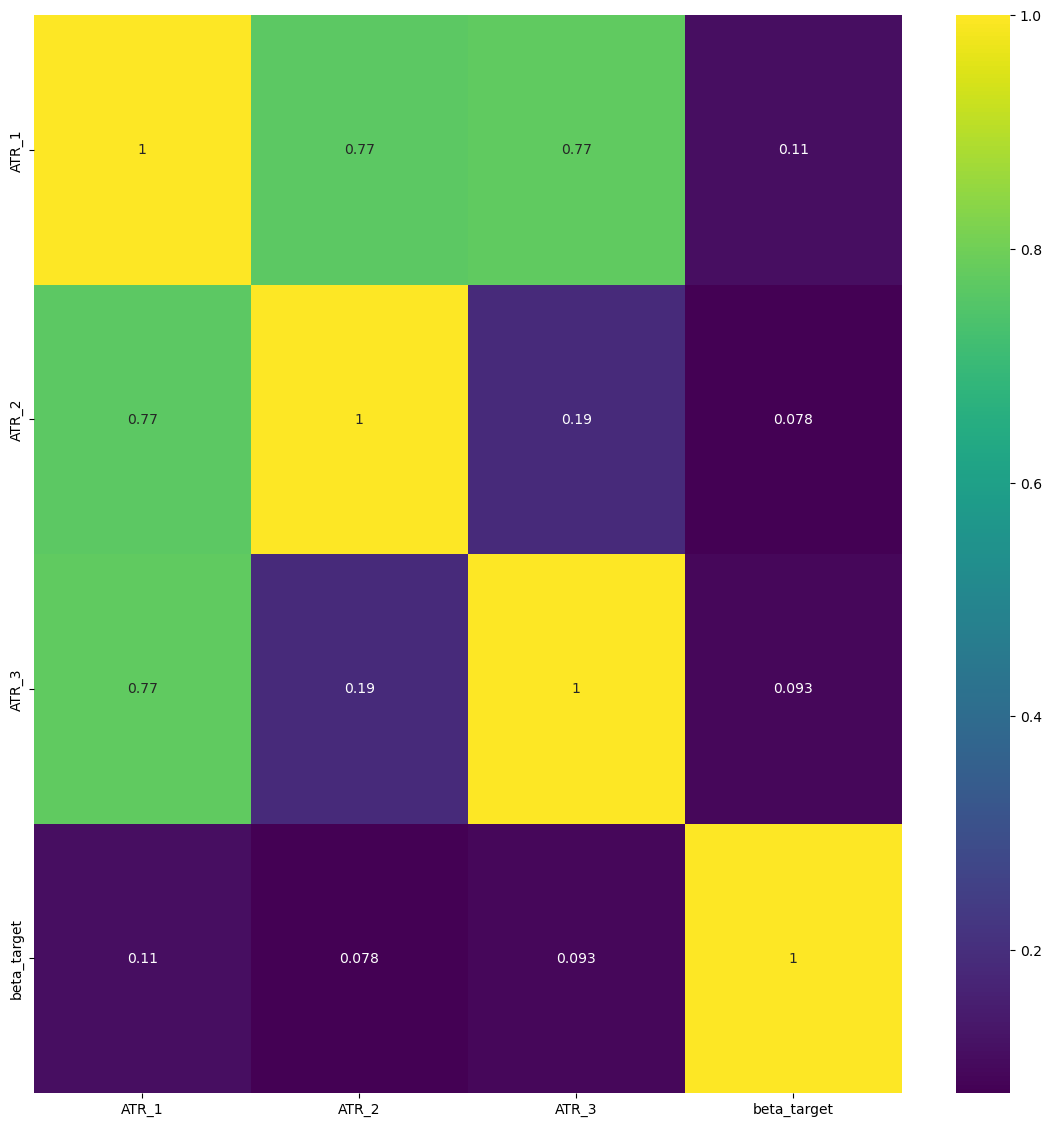

In [33]:
feature_heatmap(['ATR_1', 'ATR_2', 'ATR_3'])

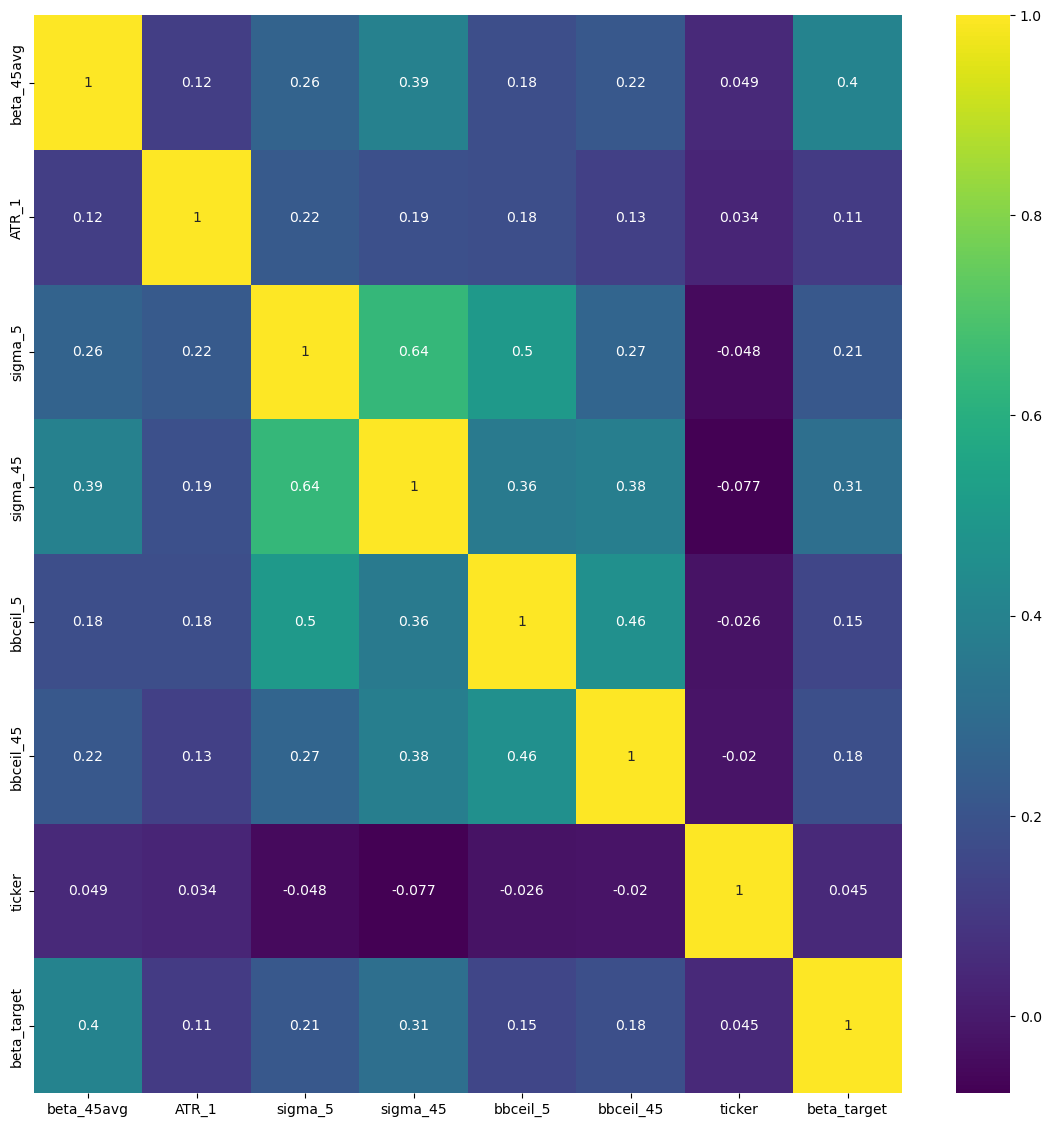

In [34]:
train['ticker'] = train.index.get_level_values(0)
train['month'] = train.index.get_level_values(1).month 
train['week'] = train.index.get_level_values(1).isocalendar().week.values
atr_feats = [f'ATR_{i+1}' for i in range(3)]
vol_feats = [f'sigma_{i}' for i in vol_windows]

# cat_feats = ['ticker', 'month', 'week']
cat_feats =['ticker']
train[cat_feats] = train[cat_feats].astype('category')

custom_picked_feats = [
    'beta_45avg', 
    'ATR_1', 
    'sigma_5', 
    'sigma_45',
    'bbceil_5', 
    'bbceil_45', 
    ]


# beta_feature_list = atr_feats+vol_feats+bb_feats +cat_feats
beta_feature_list =custom_picked_feats+cat_feats

feature_heatmap(beta_feature_list, ['beta_target'])


holdout = 2021


# train['beta'] = np.log1p(train['beta'])
nan_cuttoff_date = '2017-3-10'
train = train.drop(index = 1592, axis = 0).loc[idx[:, nan_cuttoff_date:'2021-11-15'],:]
X = train.loc[idx[:, '2017':str(holdout-1)], beta_feature_list].copy()
y = train.loc[idx[:, '2017': str(holdout-1)], 'beta_target'].copy()

X_holdout = train.loc[idx[:, str(holdout)], beta_feature_list].copy()
y_holdout = train.loc[idx[:, str(holdout)], 'beta_target'].copy()



In [35]:
y.dropna()

Code  Date      
1301  2017-03-10    0.465159
      2017-03-13    0.464988
      2017-03-14    0.486837
      2017-03-15    0.482105
      2017-03-16    0.493320
                      ...   
9997  2020-12-24    0.569926
      2020-12-25    0.564886
      2020-12-28    0.530331
      2020-12-29    0.488962
      2020-12-30    0.581217
Name: beta_target, Length: 1732585, dtype: float64

# Cross validation scheme

I'll use a custom cross validator from Stefan Jansen's github that accepts a multindex dataframe has a class argument.  
* Leave the most recent year out as a holdout set for evaluation
* I'll make my train period 1 year to capture any seasonal effects, and test on half a year
* Using the time seires walk forward approach, data on January 2017 - December 2021 should yield about **6** training and validation sets with **1** holdout test set on the full year  of 2021

In [36]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(1).unique()
        days = sorted(unique_dates, reverse=True)
        # days = unique_dates
        # days = sorted(unique_dates, reverse=False)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()['Date']
        # self.dates = dates
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates > days[train_start])
                              & (dates <= days[train_end])].index
            test_idx = dates[(dates > days[test_start])
                             & (dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

cv = MultipleTimeSeriesCV(n_splits=6, train_period_length=220-45, test_period_length=110, lookahead=45)

i = 0
for train_idx, test_idx in cv.split(X=X):
    X_train = X.iloc[train_idx]
    train_dates = X_train.index.get_level_values(1)
    X_test = X.iloc[test_idx]
    test_dates = X_test.index.get_level_values(1)
    df = pd.concat((X_train.reset_index(), X_test.reset_index()), axis = 0)
    n = len(df)
    # assert n== len(df.drop_duplicates())
    print(X_train.groupby(level=0).size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          X_test.groupby(level=0).size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break


219 2019-06-20 2020-05-18 110 2020-07-20 2020-12-30
219 2019-01-04 2019-11-28 110 2020-02-06 2020-07-17
219 2018-07-23 2019-06-18 110 2019-08-22 2020-02-05
219 2018-02-09 2018-12-27 110 2019-03-08 2019-08-21
219 2017-08-29 2018-07-19 110 2018-09-21 2019-03-07
219 2017-03-21 2018-02-07 110 2018-04-13 2018-09-20


In [37]:
model_names = [f'model_{i}' for i in range(cv.n_splits)]
metrics_df = pd.DataFrame(
    index = ['rmse', 'mae', 'pearson_r', 'spearman_r']
    , columns = model_names
)
train_predictions = pd.DataFrame(index = X.index.to_numpy(), columns = model_names)

xgb_models = {}
xgb_cv_results = {}

xgb_params = {
    'enable_categorical': True,
    'n_estimators': 3000,
    'verbose': False,
    'early_stopping_rounds': 100,
    'eta': 0.005,
    'objective':'reg:squarederror',
    'verbosity':0,
    'eval_metric': ['rmse', 'mae'],
    'max_depth': 6,#6,
    # 'gamma': 0.5,
    'min_child_weight': 1,
    'booster': 'gbtree',
    'tree_method': 'hist',
    'sampling_method': 'gradient_based',
    'subsample':0.1,
    'colsample_bytree':0.5,
    'colsample_bylevel': 1,
    # 'alpha': 200,#10,
    # 'lambda': 300,#30,
    'device': 'cuda',
}
for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    model_no = f'model_{i}'

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(**xgb_params)
    eval_set = (X_test, y_test)
    eval_results = []
    model.fit(
        X = X_train, y= y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    xgb_models[model_no] = model
    xgb_cv_results[model_no] = model.evals_result()

    ypred_test = model.predict(X_test)

    metrics_df.loc['rmse', model_no] = mean_squared_error(y_test, ypred_test, squared=False)
    metrics_df.loc['mae', model_no] = mean_absolute_error(y_test, ypred_test)
    metrics_df.loc['pearson_r', model_no] = pearsonr(y_test, ypred_test)[0]
    metrics_df.loc['spearman_r', model_no] = spearmanr(y_test, ypred_test)[0]
    train_predictions.loc[:, model_no] = model.predict(X)


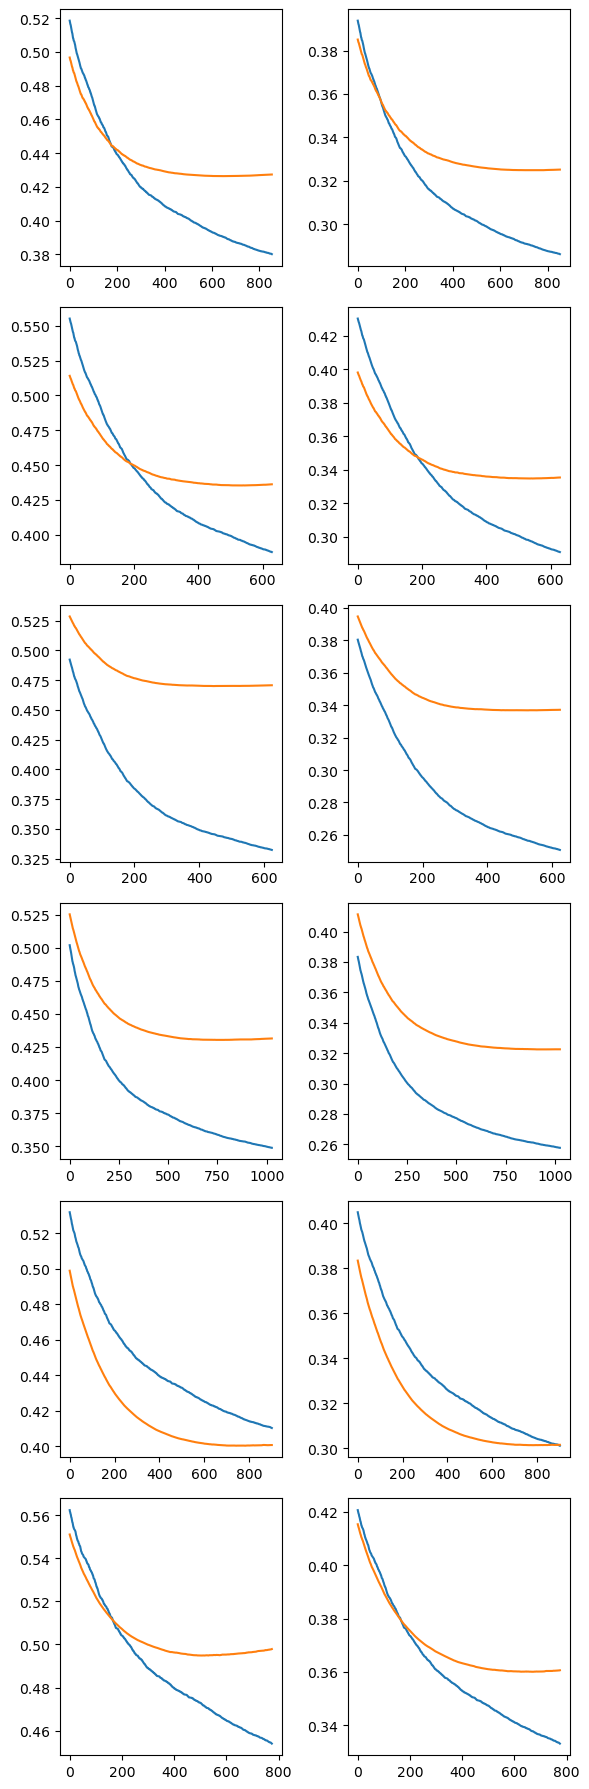

In [38]:
fig, ax = plt.subplots(cv.n_splits, 2, figsize = (3*2, 18), tight_layout = True)
for i, fold_no in enumerate(xgb_cv_results.keys()):

    fold = xgb_cv_results[fold_no]

    for j, set_no in enumerate(fold.keys()):
        set = fold[set_no]
        for k, metric in enumerate(set.keys()):
            data = np.array((set[metric]))
            ax[i, k].plot(data)
            

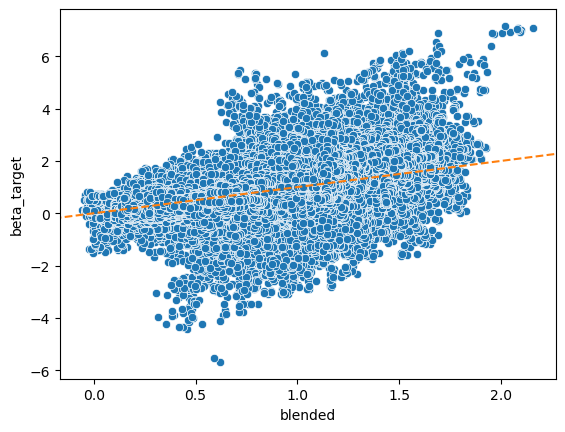

In [39]:
metrics_df.loc['pearson_weight'] = metrics_df.loc['pearson_r']/metrics_df.loc['pearson_r'].sum()
train_predictions['blended'] = (train_predictions*metrics_df.loc['pearson_weight']).sum(axis = 1)

fig, ax = plt.subplots()

sns.scatterplot(x=train_predictions['blended'],y= y)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y.min(), y.max()], [y.min(), y.max()], '--',color = 'tab:orange')

In [40]:
pearsonr(train_predictions['blended'], y.dropna())

PearsonRResult(statistic=0.5715277713840474, pvalue=0.0)

,model_0,model_1,model_2,model_3,model_4,model_5
rmse,0.351601,0.346075,0.343748,0.36564,0.362929,0.380422
mae,0.263978,0.258991,0.256717,0.26879,0.270206,0.285709
pearson_r,0.560453,0.574961,0.577873,0.529107,0.51404,0.420852
spearman_r,0.575848,0.58475,0.583293,0.552928,0.540431,0.464382
pearson_weight,0.176394,0.18096,0.181876,0.166528,0.161786,0.132456


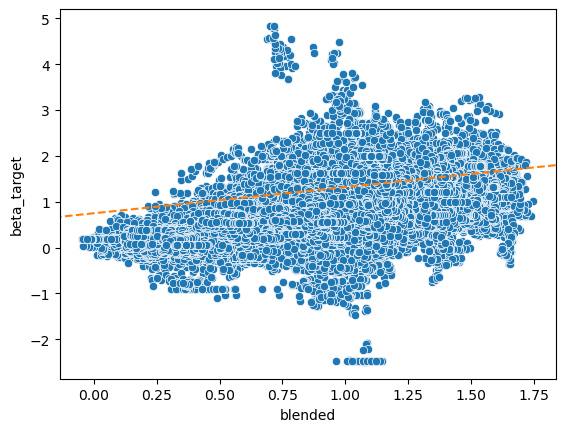

In [41]:
holdout_predictions = pd.DataFrame(columns = model_names, index = y_holdout.index)
holdout_metrics = pd.DataFrame(index = metrics_df.index, columns =metrics_df.columns)
for key in xgb_models.keys():
    model = xgb_models[key]
    ypred = model.predict(X_holdout)
    holdout_predictions[key] = ypred

    holdout_metrics.loc['rmse', key] = mean_squared_error(ypred, y_holdout, squared=False)
    holdout_metrics.loc['mae', key] = mean_absolute_error(ypred, y_holdout)
    holdout_metrics.loc['pearson_r', key] = pearsonr(ypred, y_holdout)[0]
    holdout_metrics.loc['spearman_r', key] = spearmanr(ypred, y_holdout)[0]

holdout_metrics.loc['pearson_weight']= holdout_metrics.loc['pearson_r']/holdout_metrics.loc['pearson_r'].sum()
display(holdout_metrics)

holdout_predictions['blended'] = (holdout_predictions*holdout_metrics.loc['pearson_weight']).sum(axis=1)

fig, ax = plt.subplots()

sns.scatterplot(x=holdout_predictions['blended'],y= y_holdout)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y.min(), y.max()], [y_holdout.min(), y_holdout.max()], '--',color = 'tab:orange')

In [42]:
pearsonr(holdout_predictions['blended'], y_holdout)

PearsonRResult(statistic=0.6039086785472791, pvalue=0.0)

# Analyze a few time series

In [43]:
# ticker = 4628
# df = pd.concat([train, holdout_predictions], axis = 1).loc[idx[ticker, str(holdout)]]
# fig, ax = plt.subplots()

# sns.lineplot(df, x = 'Date', y= 'beta', ax = ax)
# sns.lineplot(df, x = 'Date', y = 'blended', ax = ax)